# Air Quality Analysis in Beijing


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [3]:
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

## Data Collection

In [4]:
data_file = "Beijing_Multisite_air_Quality_data.csv"
data_df = pd.read_csv(data_file)
data_df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
print(f"DataFrame Shape: {data_df.shape}\n")
data_df.info()

DataFrame Shape: (420768, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       418946 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 54.6+ MB


In [6]:
data_df.groupby('station').size().reset_index(name='row_count')

,station,row_count
0,Aotizhongxin,35064
1,Changping,35064
2,Dingling,35064
3,Dongsi,35064
4,Guanyuan,35064
5,Gucheng,35064
6,Huairou,35064
7,Nongzhanguan,35064
8,Shunyi,35064
9,Tiantan,35064


### For this project, we are focusing on the first two stations, 'Aotizhongxin' and 'Changping'.

In [7]:
filtered_df = data_df[data_df['station'].isin(['Aotizhongxin', 'Changping'])]
filtered_df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


## Data Cleaning

In [8]:
filtered_df.isnull().sum()

year          0
month         0
day           0
hour          0
PM2.5      1699
PM10       1300
SO2        1563
NO2        1690
CO         3297
O3         2323
TEMP         73
PRES         70
DEWP         73
RAIN         71
wd          221
WSPM         57
station       0
dtype: int64

In [9]:
filtered_df.drop(columns=['TEMP','PRES','DEWP','RAIN','wd','WSPM'], inplace=True)

In [10]:
numerical_filtered_df = filtered_df.select_dtypes(include=['number'])
mean_median_diff = numerical_filtered_df.mean() - numerical_filtered_df.median()
print("Differences between Mean and Median\n", mean_median_diff)

Differences between Mean and Median
 year      -0.337440
month     -0.477070
day       -0.270363
hour       0.000000
PM2.5     24.923797
PM10      23.343914
SO2        8.161992
NO2        7.704624
CO       407.412159
O3        12.159726
dtype: float64


In [11]:
mode = numerical_filtered_df.mode().iloc[0]
mean = numerical_filtered_df.mean()
median = numerical_filtered_df.median()

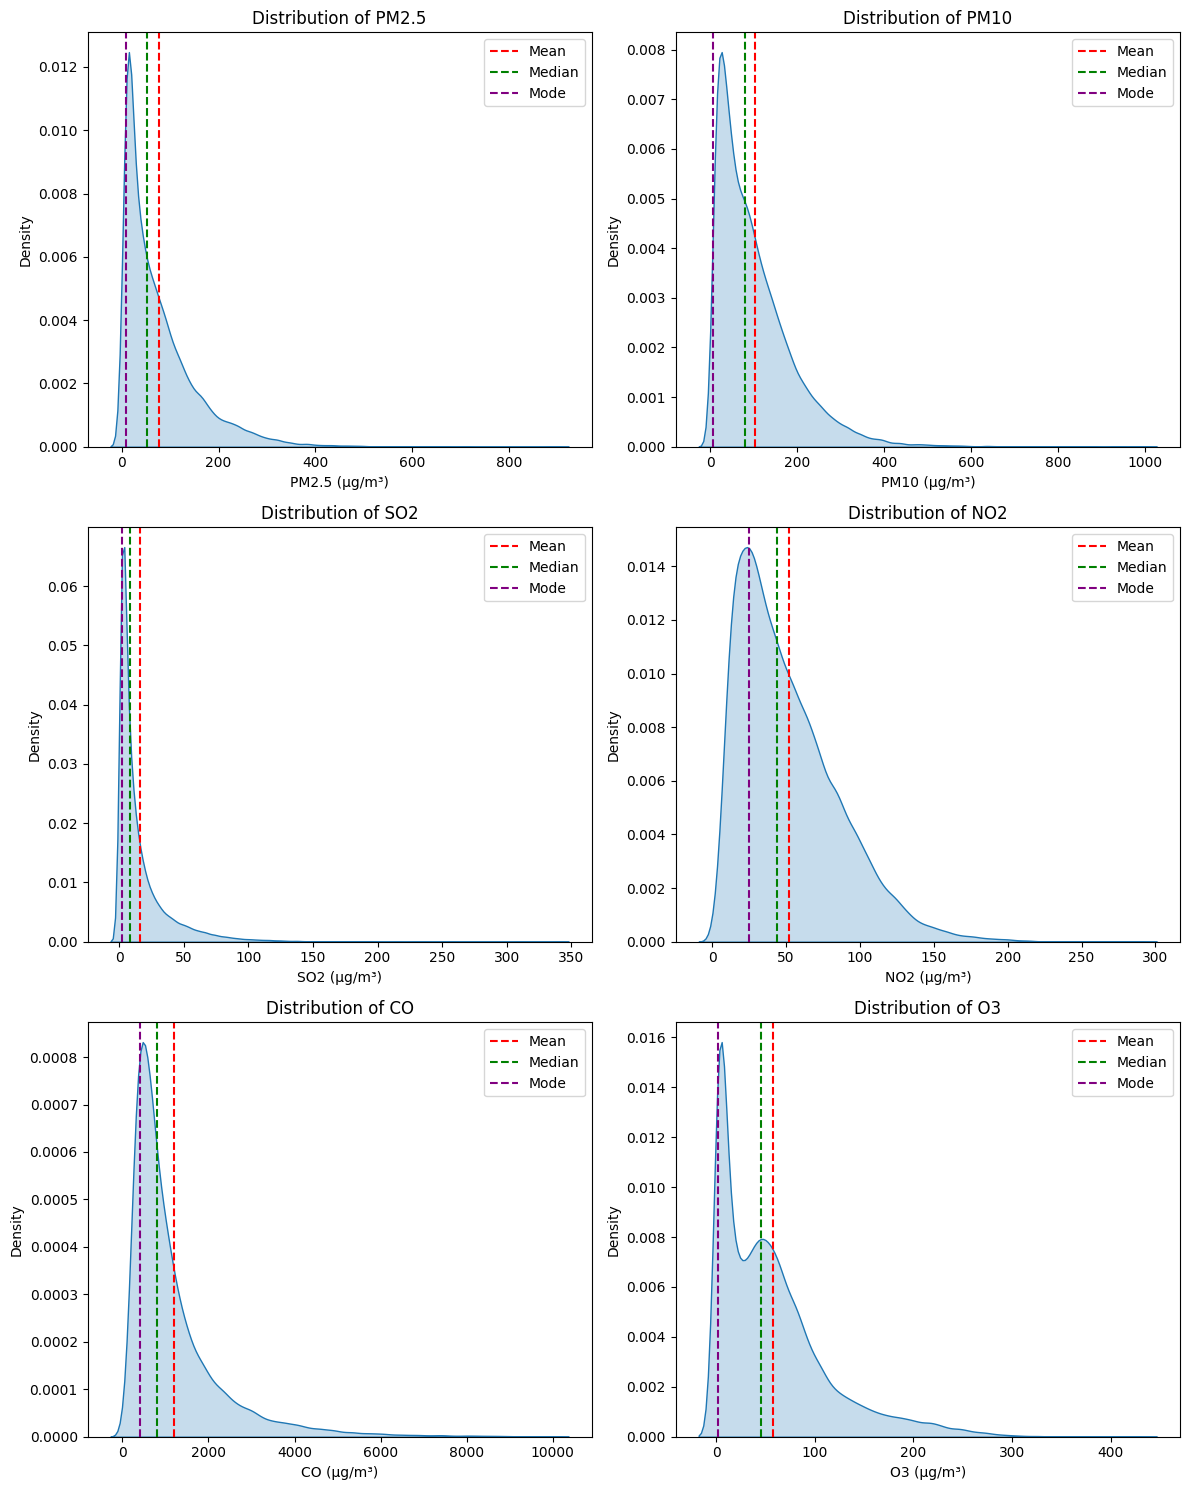

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))  
axes = axes.flatten()

columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

for i, column in enumerate(columns):
    sns.kdeplot(numerical_filtered_df[column], fill=True, ax=axes[i])
    axes[i].axvline(x=mean[column], color='red', linestyle='--', label='Mean')
    axes[i].axvline(x=median[column], color='green', linestyle='--', label='Median')
    axes[i].axvline(x=mode[column], color='purple', linestyle='--', label='Mode')
    axes[i].set_xlabel(f'{column} (µg/m³)')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Imputing Missing Values

In [13]:
filtered_df.fillna({
    'PM2.5': filtered_df['PM2.5'].median(),
    'PM10': filtered_df['PM10'].median(),
    'SO2': filtered_df['SO2'].median(),
    'NO2': filtered_df['NO2'].median(),
    'CO': filtered_df['CO'].median(),
    'O3': filtered_df['O3'].median()
}, inplace=True)

## Summary Statistics

In [14]:
# List of parameters to compute summary statistics for
parameters = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

def summary_statistics(station_name):
    station_df = filtered_df[filtered_df['station'] == station_name]
    return station_df[parameters].agg(['mean', 'median', 'std', 'var', 'min', 'max'])


aotizhongxin_stats = summary_statistics('Aotizhongxin')

changping_stats = summary_statistics('Changping')


In [15]:
print(aotizhongxin_stats)

              PM2.5         PM10         SO2          NO2            CO           O3
mean      81.961793   109.424373   17.125888    58.859282  1.239497e+03    55.796764
median    56.000000    84.000000    8.000000    52.000000  8.000000e+02    45.000000
std       81.194965    94.345610   22.567267    36.661350  1.194422e+03    56.531959
var     6592.622390  8901.094183  509.281555  1344.054598  1.426645e+06  3195.862395
min        3.000000     2.000000    0.285600     2.000000  1.000000e+02     0.214200
max      898.000000   984.000000  341.000000   290.000000  1.000000e+04   423.000000


In [ ]:
print(changping_stats)

              PM2.5         PM10         SO2         NO2            CO           O3
mean      70.678137    94.397978   14.834271   44.178622  1.137019e+03    57.717103
median    48.000000    74.000000    7.000000   37.000000  8.000000e+02    45.000000
std       71.579210    82.770507   20.807121   29.237683  1.081251e+03    53.873125
var     5123.583240  6850.956849  432.936303  854.842085  1.169103e+06  2902.313551
min        2.000000     2.000000    0.285600    1.847700  1.000000e+02     0.214200
max      882.000000   999.000000  310.000000  226.000000  1.000000e+04   429.000000


## Time Series Plots

In [17]:
# Create a datetime column
filtered_df['datetime'] = pd.to_datetime(filtered_df[['year', 'month', 'day', 'hour']])

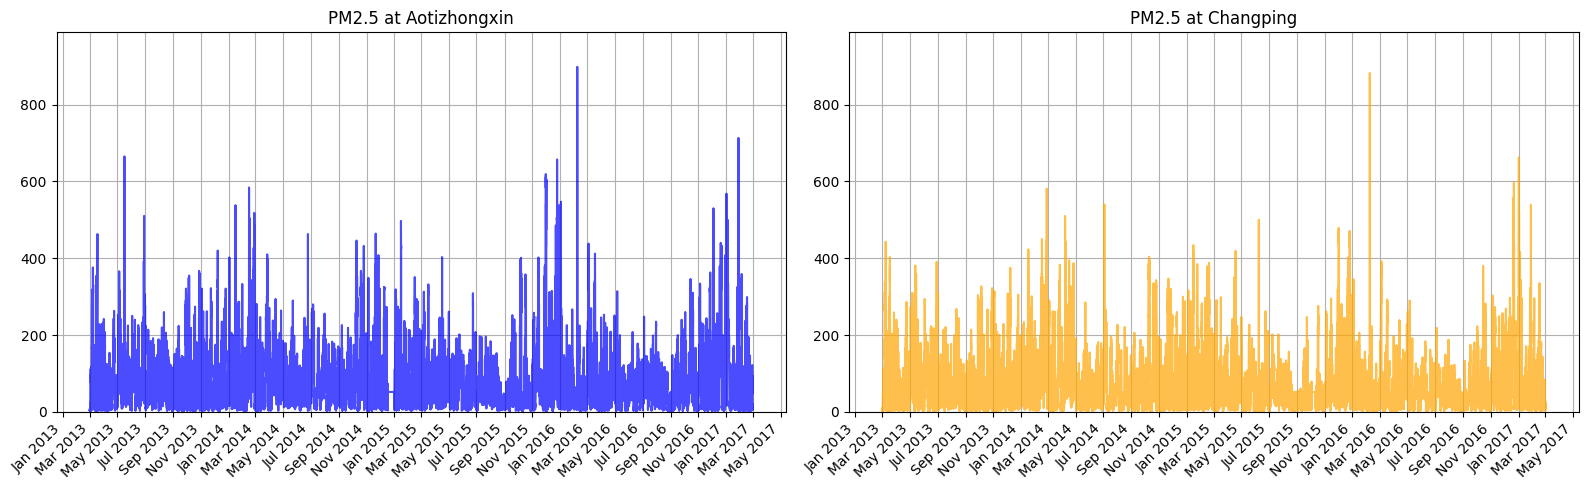

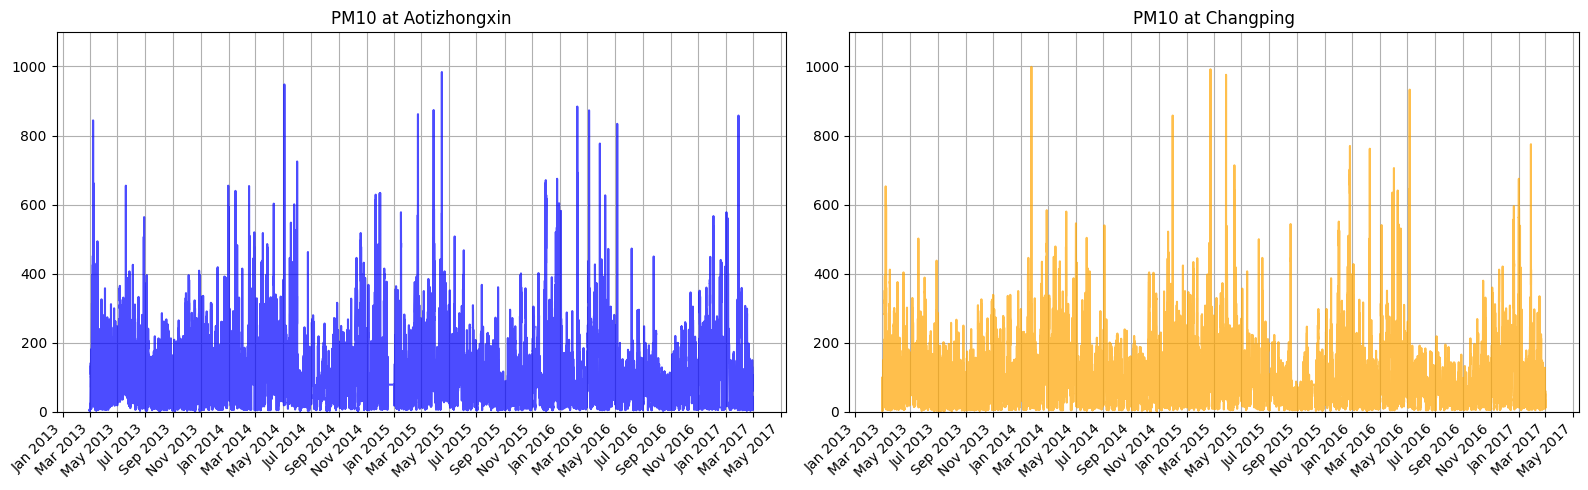

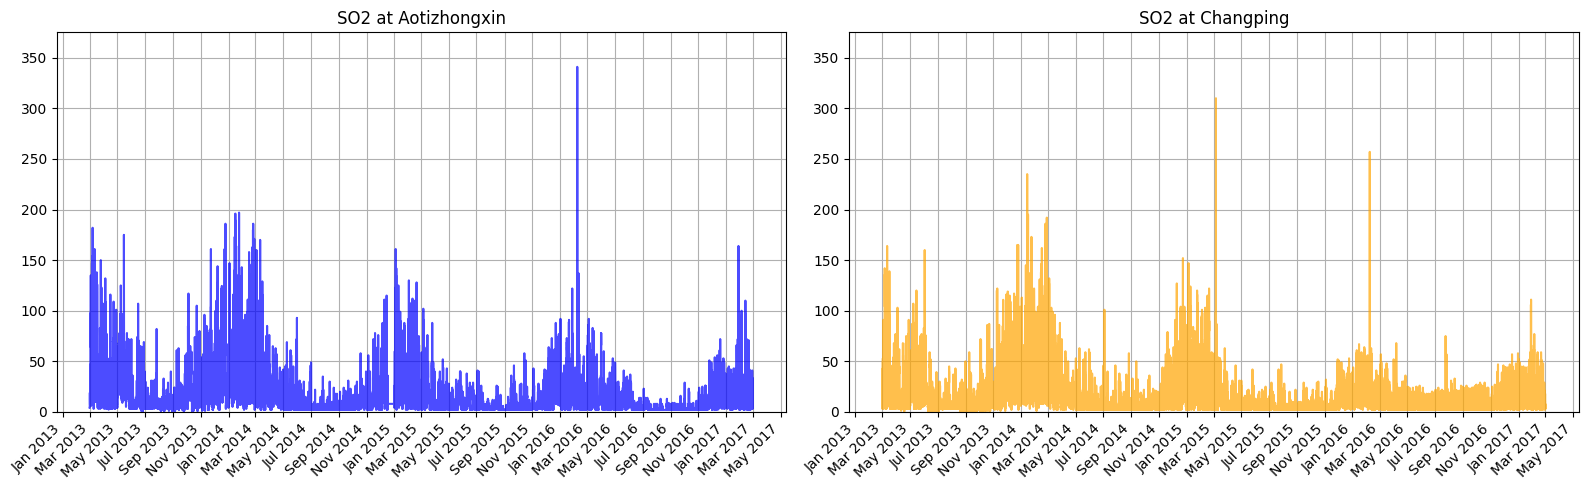

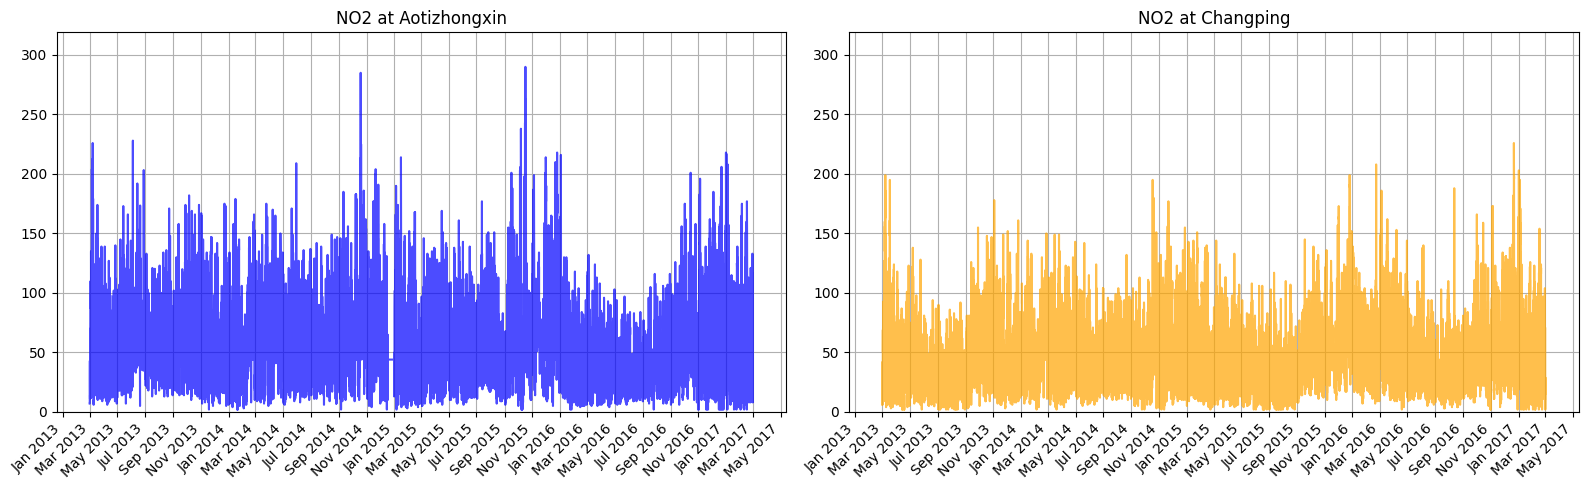

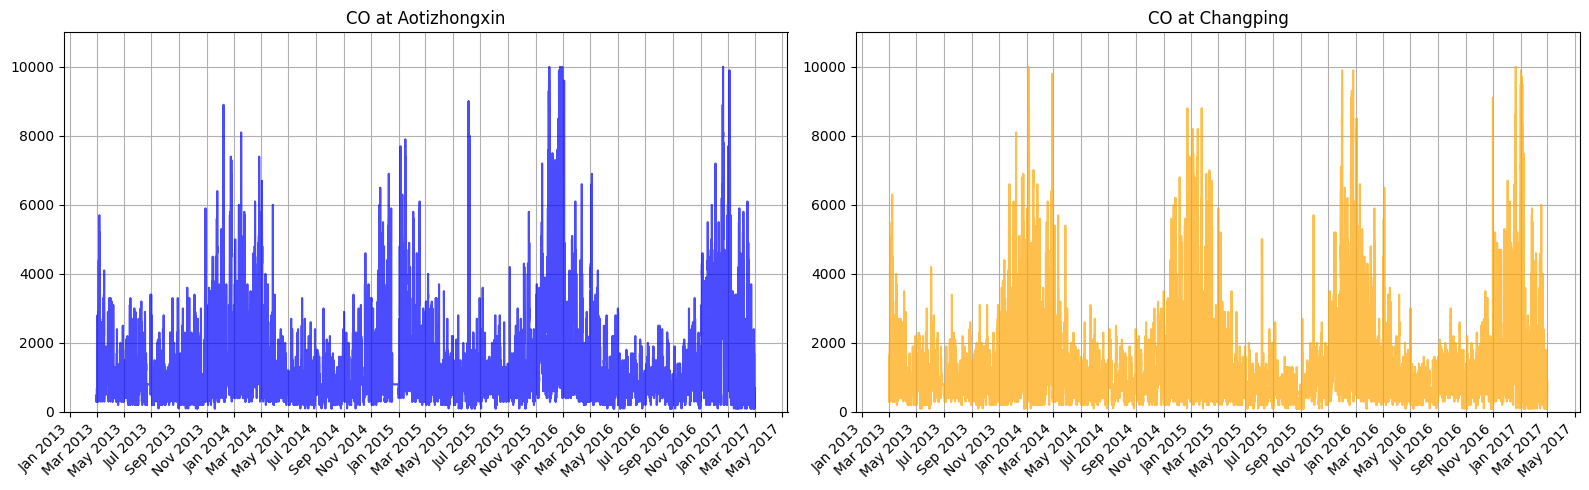

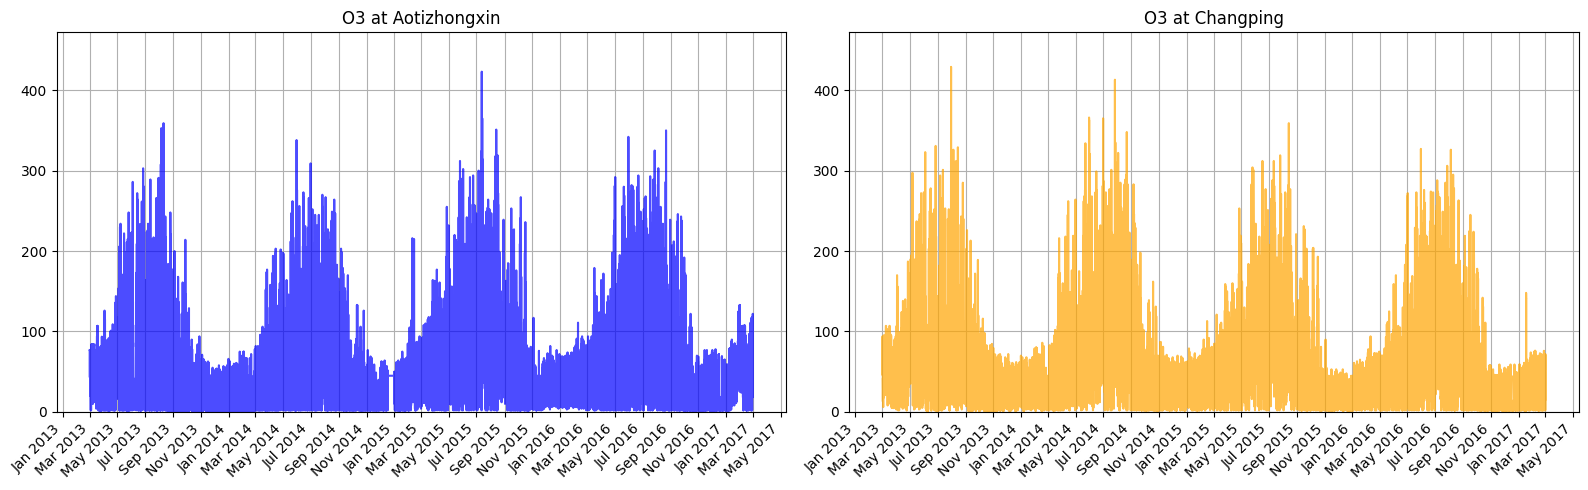

In [18]:
stations = filtered_df['station'].unique()

# Define colors for each station
colors = {stations[0]: 'blue', stations[1]: 'orange'}


# Define a function to plot the parameter for the two stations 
def plot_parameter(parameter):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), sharex=True)
    
    # Find the global maximum for the y-axis limit (for comparison)
    global_max = filtered_df[parameter].max()
    
    for j, station in enumerate(stations):
        station_data = filtered_df[filtered_df['station'] == station]
        
        # Plot the data for the given parameter and station
        axes[j].plot(station_data['datetime'], station_data[parameter], 
                     color=colors[station], alpha=0.7, label=station)
        
        # Set titles and labels
        axes[j].set_title(f'{parameter} at {station}')
        axes[j].grid()
        
        # Set y-axis to be the same for both stations (using the max value)
        axes[j].set_ylim(0, global_max * 1.1)  # Adding 10% buffer for better visualization
    

    # Set x-ticks for all subplots to show every 2 months with 'Month Year' format
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Set 2-month intervals
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format for month and year ('Jan 2013')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')  # Rotate x-tick labels for readability

    plt.tight_layout()
    plt.show()

# Loop through each parameter and plot
for parameter in parameters:
    plot_parameter(parameter)

## Histograms

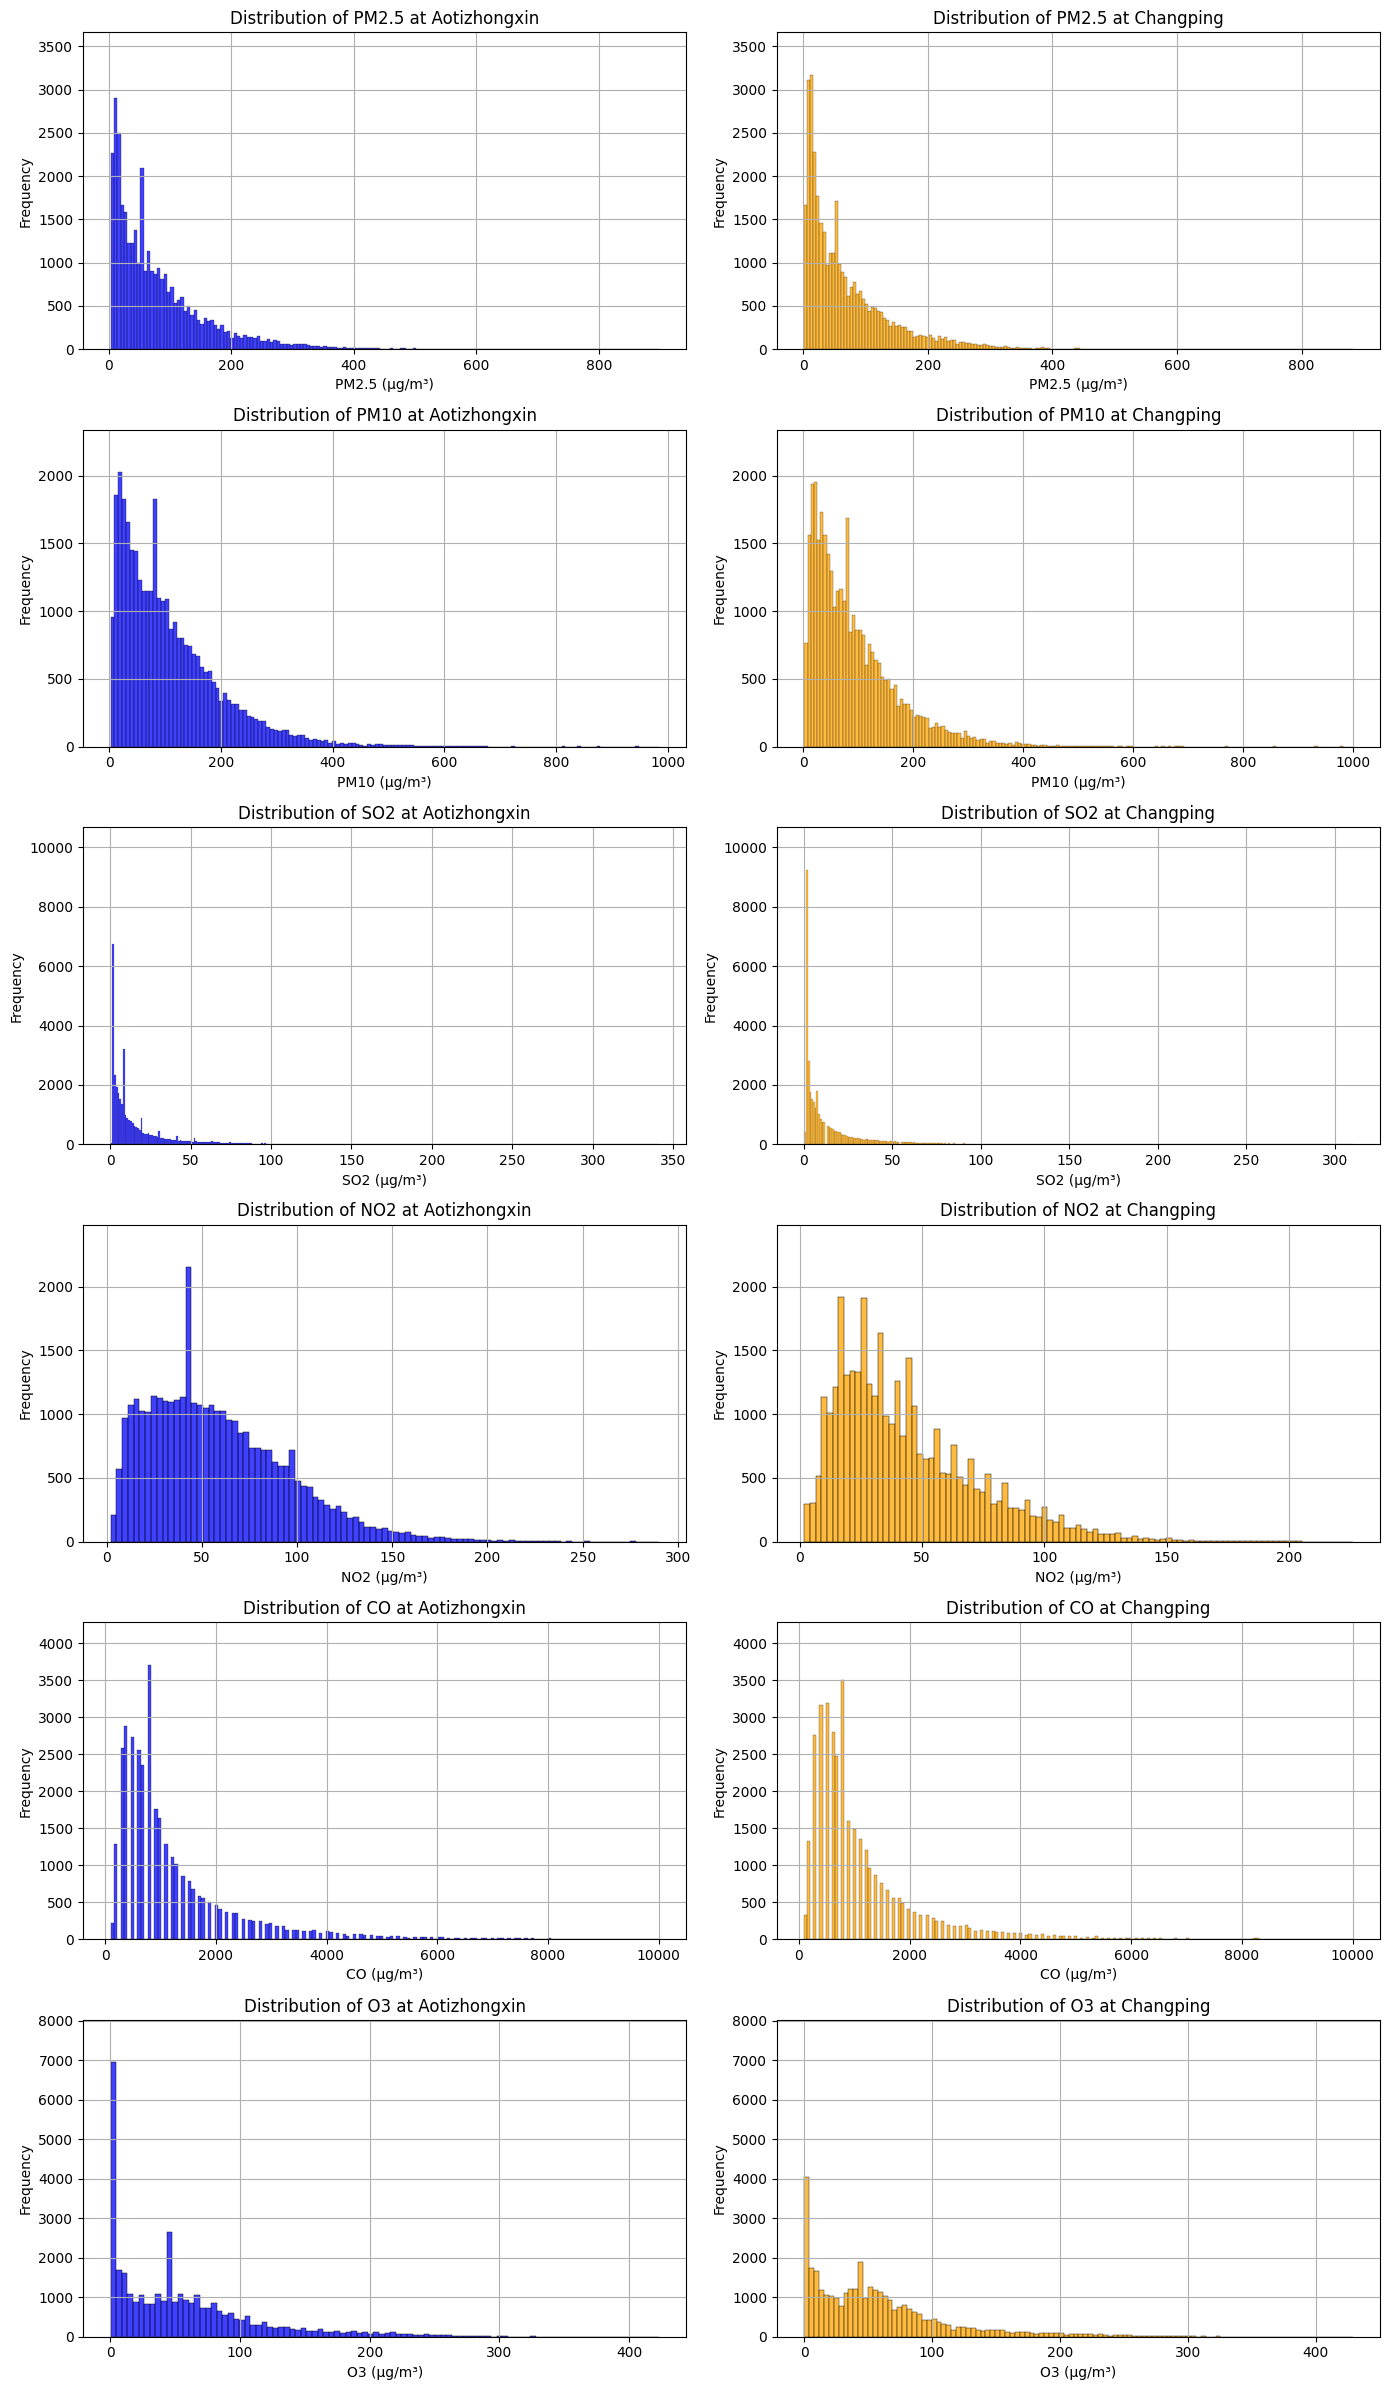

In [19]:
# Create subplots
fig, axes = plt.subplots(len(parameters), 2, figsize=(14, 4 * len(parameters)))

# Loop through each parameter and create histograms for each station
for i, parameter in enumerate(parameters):
    
    for j, station in enumerate(stations):
        station_data = filtered_df[filtered_df['station'] == station]
        
        # Plot the histogram 
        sns.histplot(station_data[parameter], bins='auto', ax=axes[i, j],
                     color='blue' if station == 'Aotizhongxin' else 'orange')
        
        # Set titles and labels
        axes[i, j].set_title(f'Distribution of {parameter} at {station}')
        axes[i, j].set_xlabel(f'{parameter} (µg/m³)')  

        axes[i, j].set_ylabel('Frequency')
        axes[i, j].grid(True)
    
    # Retrieve the max y-limit from both subplots for the current parameter
    max_y_value = max(axes[i, 0].get_ylim()[1], axes[i, 1].get_ylim()[1])
    
    # Set the same y-axis limit for both subplots for consistency
    axes[i, 0].set_ylim(0, max_y_value * 1.1)  # Add a 10% buffer
    axes[i, 1].set_ylim(0, max_y_value * 1.1)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


## Correlation Analysis

## Trend Analysis

## Reporting